## 1. Problem Statement

- We want to reduce the time a Mercedes-Benz spends on the test bench.
- To ensure the safety and reliability of every unique car configuration before they hit the road, the company’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Mercedes-Benz’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

- You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Mercedes-Benz’s standards.

## 2 Importing Libraries

In [ ]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action="once")
#warnings.filterwarnings(action="ignore")
%matplotlib inline

In [ ]:
# igonore all categories of warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures,LabelEncoder, RobustScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV, train_test_split

## 2 Loading the Data and Exploring it at a high level.

In [99]:
# import the data
df = pd.read_csv('train.csv')
df.head()


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

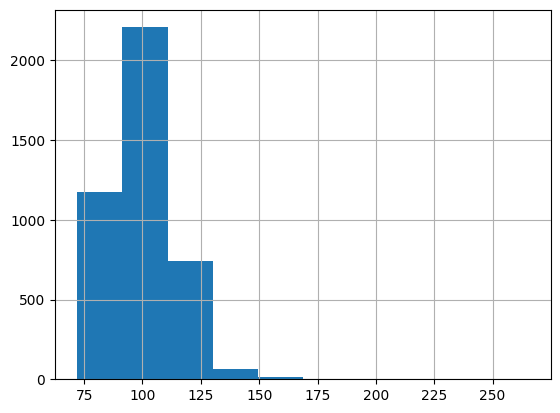

In [ ]:
# plot a histogram of the target variable
df['y'].hist()


## 3. Prelim EDA
- Check for missingness
- Check for duplicates
- Check types of columns
- Check for outliers
- Descriptive Stats



In [ ]:
# check for missingness
# df.isnull().sum().sort_values(ascending=False)
# No missing values

In [102]:
# separate categorical from the numerical features
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns
print(num_cols.shape, cat_cols.shape)

(370,) (8,)


In [103]:
cat_cols

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [104]:
# drop the ID column and y
X = df.drop(['ID', 'y'], axis=1)
X[cat_cols].head(2)

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o


In [105]:
# get the number of unique values in each categorical column
for col in cat_cols:
    print(col, X[col].nunique())

X0 47
X1 27
X2 44
X3 7
X4 4
X5 29
X6 12
X8 25


Columns XO, X2, X5 and X8 are high cardinality columns

## 4. Data Preprocessing
- Missing values treating
- Ecoding : Onehot, Ordinal , Label, Binary
- Groupings
- Creating new features out of existing ones
- Handling of outliers
- Scaling
- PCA

#### Drop Columns

In [119]:
# drop ID and y from the num_cols list
num_cols = num_cols.drop('y')
num_cols = num_cols.drop('ID')
# remove zero variance columns
zero_var_cols = [col for col in num_cols if X[col].var() == 0 ]
print(zero_var_cols)
X.drop(zero_var_cols, axis=1, inplace=True)


#### Encode Categorical Vars

In [120]:
# one hot encode the categorical columns using a column transformer
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cat_cols),remainder='passthrough')
# fit transform the data with the column transformer
X_encoded = ct.fit_transform(X)

In [121]:
X_encoded.shape, X.shape

((4209, 551), (4209, 364))

#### Scale the Data

In [122]:
# scale our data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_encoded)

#### Dimensionality reduction

In [123]:
pca = PCA()
X_pca = pca.fit(X_scaled)

Text(0.5, 1.0, 'Explained Variance vs N-Components')

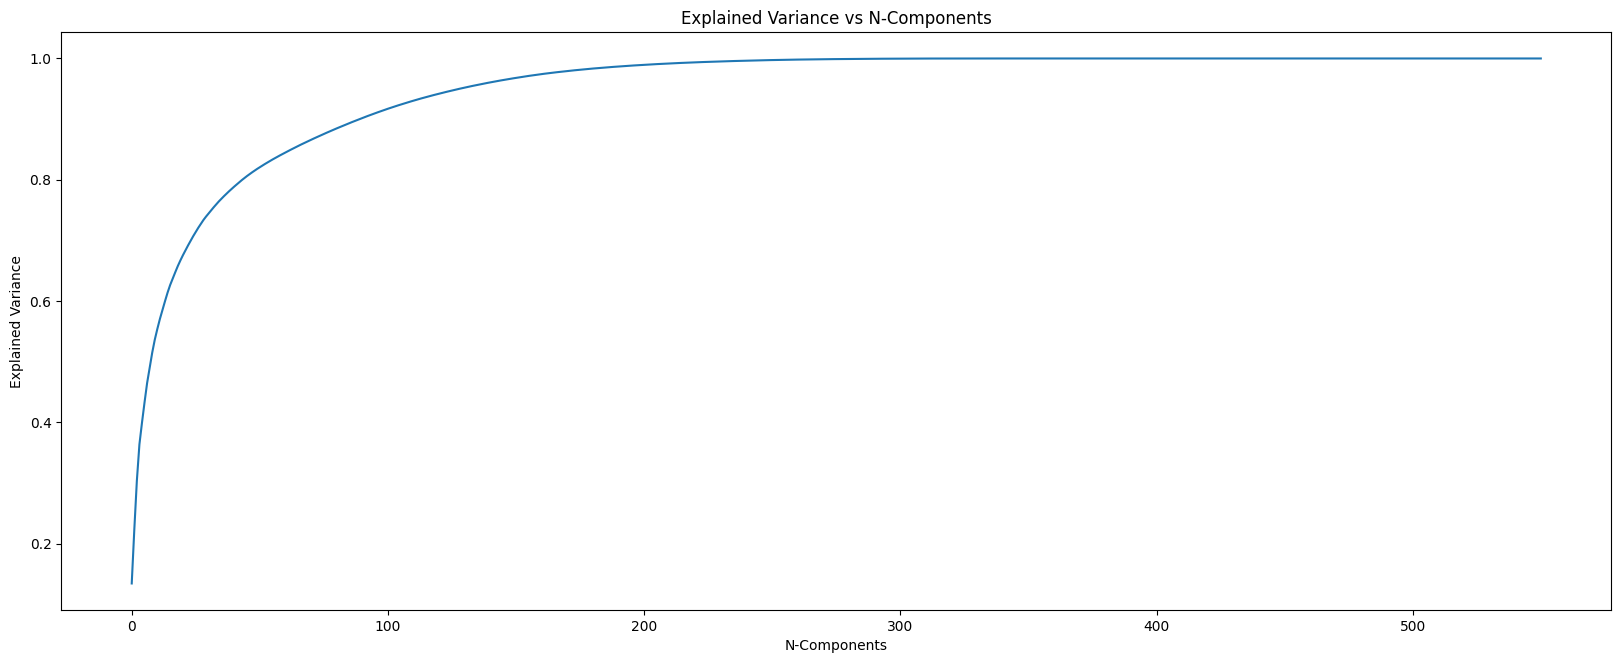

In [ ]:
variance = X_pca.explained_variance_ratio_
components = np.arange(len(variance))

plt.figure(figsize=(20,7.5))
plt.plot(components, np.cumsum(variance))
plt.ylabel("Explained Variance"), plt.xlabel("N-Components")
plt.title("Explained Variance vs N-Components")

In [139]:
# select the ideal number of features for modelling
pca = PCA(n_components=300)
X_pca = pca.fit(X_scaled)
print("Total Explained Variance: ", np.cumsum(X_pca.explained_variance_ratio_)[-1])

Total Explained Variance:  0.9987419690383016


In [140]:
X_pca = pca.fit_transform(X_scaled)
final_data = pd.DataFrame(X_pca)
# plt.figure(figsize=(20,10))
# sns.heatmap(final_data.corr().abs())

In [142]:
# define X and y
X = final_data
y = df['y']
y.shape, X.shape

((4209,), (4209, 300))

## 5. ML Modelling
- Linear Models : MLR, LASSO, RIDGE, ELASTICNET,
- Non-linear Models : RF, BOOSTED MODELS, SVR

In [ ]:
# Cross validated modelling
# Non-linear models perform better with this kind of data

# Linear Regression
pipe = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
print(scores, scores.mean())

[-62.5260802   -1.09710343 -21.11641459  -0.89554352 -66.22905455] -30.372839257960937


In [143]:
# Ridge Regression
pipe = make_pipeline(PolynomialFeatures(degree=1), Ridge(alpha=10))
scores = cross_val_score(pipe, X, y, cv=10, scoring="r2")
print(scores, scores.mean())

[0.56787141 0.60129683 0.34739951 0.51971511 0.66602753 0.53676104
 0.46873218 0.59848756 0.61582227 0.62942273] 0.5551536159544672


In [144]:
# KernelRidge
pipe = make_pipeline(KernelRidge(kernel= 'poly', degree= 2, alpha= 1))
scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
print(scores, scores.mean())

[0.58228913 0.42255148 0.59264967 0.53377152 0.61826264] 0.54990489169756


In [145]:
# Lasso
pipe = make_pipeline(PolynomialFeatures(degree=1), Lasso(alpha=0.1))
scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
print(scores, scores.mean())

[0.55868466 0.40351638 0.56430623 0.50890006 0.58908642] 0.524898749600081


In [ ]:
# Random Forest
model = RandomForestRegressor()
scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(scores, scores.mean())

In [ ]:
# SVR
model = SVR(kernel='rbf',degree=5,C=10)
scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(scores, scores.mean())

[0.5364699  0.39034729 0.55669311 0.48216352 0.65239433] 0.5236136277200195


In [79]:
# Boosted Regression Model
model = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss="square")
scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(scores, scores.mean())

[ 0.13067958  0.19057708  0.02806155  0.15261643 -0.08615903] 0.08315512330099387


## Hyperparameter Tuning

In [96]:
# hyperparameter tuning support vector regression with random search cv
alphas = [0, 0.01, 0.1, 1, 5, 10, 100]
degrees = [1,2,3]
kernel = ['linear', 'poly', 'rbf',]
param_grid = dict(degree = degrees, alpha = alphas,kernel=kernel)
print(param_grid)

{'degree': [1, 2, 3], 'alpha': [0, 0.01, 0.1, 1, 5, 10, 100], 'kernel': ['linear', 'poly', 'rbf']}


In [97]:
# define the Randomized Search CV
KernelRidge = KernelRidge()
reg = RandomizedSearchCV(KernelRidge, param_grid, cv=5, scoring="r2")
reg.fit(X,y)

print(reg.best_score_, reg.best_params_)

0.5491703277935405 {'kernel': 'poly', 'degree': 2, 'alpha': 1}


## Predicting the test data with the best performer

In [57]:
# import test data
test_df = pd.read_csv('https://raw.githubusercontent.com/srividya-sundaravadivelu/Mercedes-Benz-Greener-Manufacturing./main/test.csv')
test_df.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [108]:
# drop the ID column and y
test_df = test_df.drop(['ID'], axis=1)
# test_df[cat_cols].head(2)


In [110]:
# separate categorical from the numerical features
test_cat_cols = test_df.select_dtypes(include='object').columns
test_num_cols = test_df.select_dtypes(exclude='object').columns
print(test_num_cols.shape, test_cat_cols.shape)

(368,) (8,)


In [111]:
# remove zero variance columns in test data
test_df.drop(zero_var_cols, axis=1, inplace=True)
test_df.shape

(4209, 364)

In [112]:
# one hot encode the categorical columns using a column transformer
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), test_cat_cols),remainder='passthrough')

# fit transform the data with the column transformer
test_df_encoded = ct.fit_transform(test_df)
test_df_encoded.shape

(4209, 557)

In [113]:
# scale our data
scaler = RobustScaler()
test_df_scaled = scaler.fit_transform(test_df_encoded)

In [114]:
pca = PCA(n_components=200)
test_df_pca = pca.fit_transform(test_df_scaled)
test_final_df = pd.DataFrame(test_df_pca)
test_final_df.shape

(4209, 200)

In [136]:
# predict the test data using the best model above
from sklearn.kernel_ridge import KernelRidge
model = KernelRidge(kernel= 'poly', degree= 2, alpha= 1)
model.fit(X,y)
y_pred = model.predict((test_final_df))


In [137]:
#prepare submisssion data
test_df = pd.read_csv('https://raw.githubusercontent.com/srividya-sundaravadivelu/Mercedes-Benz-Greener-Manufacturing./main/test.csv')
sub_df = pd.DataFrame({'ID': test_df['ID'], 'y': y_pred})
sub_df.head()

,ID,y
0,1,85.242938
1,2,91.337250
2,3,85.987835
3,4,84.503528
4,5,110.702694


In [138]:
# save the submission data
sub_df.to_csv('submission.csv', index=False)
